<a href="https://colab.research.google.com/github/gopikrishnachaganti/llm_workshop/blob/main/arize_voice_application_emotion_evals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
    <p style="text-align:center">
    <img alt="arize logo" src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="300"/>
        <br>
        <a href="https://docs.arize.com/arize/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/client_python">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-11t1vbu4x-xkBIHmOREQnYnYDH1GDfCg">Slack Community</a>
    </p>
</center>

<center><h1> Voice Application Evals </h1></center>

## Overview
Evaluations are essential to understanding how well your model is performing in real-world scenarios, allowing you to identify strengths, weaknesses, and areas of improvement.

Offline evaluations are run as code and then sent back to Arize using `log_evaluations_sync`.

This guide assumes you have traces in Arize and are looking to run an evaluation to measure your voice application performance.


In [ ]:
!!pip install "aiohttp==3.11.11" "pandas==2.2.2" "arize==7.31.1" "arize-phoenix==7.7.2" "arize-phoenix-evals==0.19.0" "arize-phoenix-otel==0.6.1" "openai==1.59.6"

In [ ]:
import asyncio
import base64
import sys
import nest_asyncio
import aiohttp
import pandas as pd


from phoenix.evals import OpenAIModel
from phoenix.evals.classify import llm_classify
from phoenix.evals.templates import (
    ClassificationTemplate,
    PromptPartContentType,
    PromptPartTemplate,
)

from phoenix.evals.default_audio_templates import EMOTION_AUDIO_RAILS, EMOTION_PROMPT_TEMPLATE

## Import your spans in code

Once you have traces in Arize, you can visit the LLM Tracing tab to see your traces and export them in code. By clicking the export button, you can get the boilerplate code to copy paste to your evaluator.

You can find the API Keys in the **Space Setting Page:**
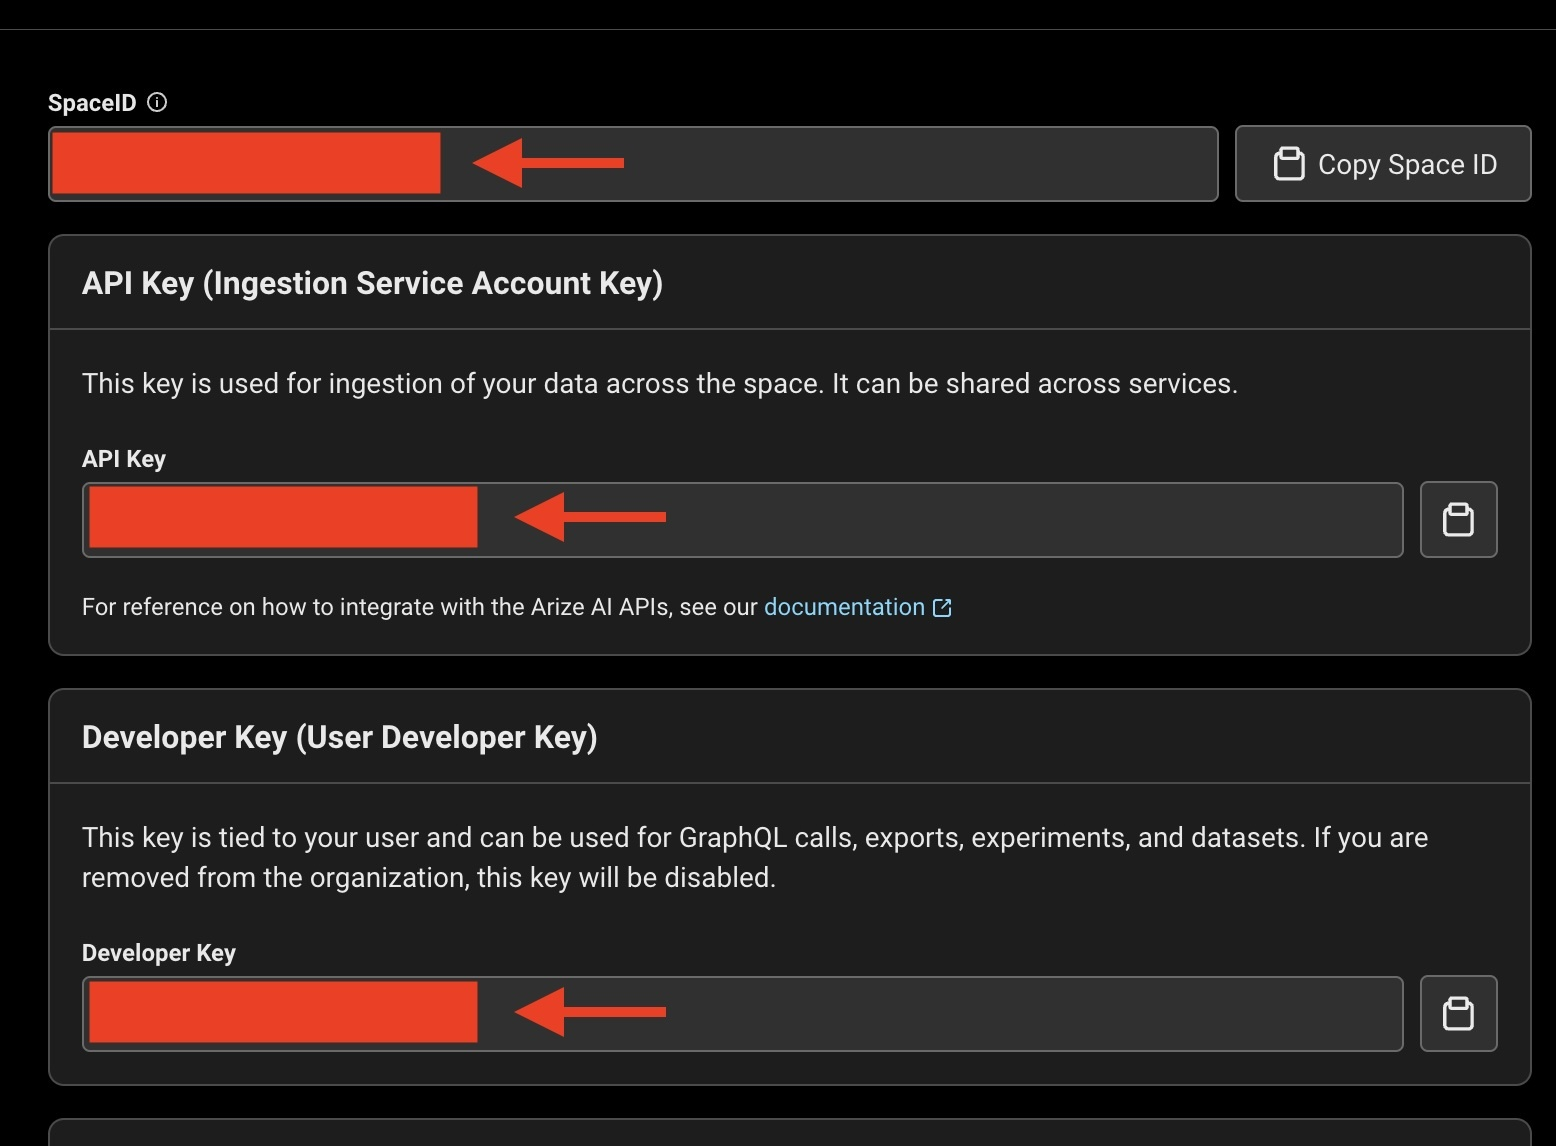

In [ ]:

import os
from datetime import datetime

from arize.exporter import ArizeExportClient
from arize.utils.types import Environments


DEVELOPER_KEY = '' #Developer key from Space Settings
SPACE_ID = '' #Space ID from Space Settings
MODEL_ID = '' #Model Name


client = ArizeExportClient(api_key=DEVELOPER_KEY)

print('#### Exporting your dataset into a dataframe.')


data = client.export_model_to_df(
    space_id=SPACE_ID,
    model_id=MODEL_ID,
    environment=Environments.TRACING,
    start_time=datetime.fromisoformat('2025-01-09T07:00:00.000+00:00'),
    end_time=datetime.fromisoformat('2025-01-17T06:59:59.999+00:00')
    )



For this example, we are only interested in running the eval on our input audio. For that reason we will filter for those spans. For example, if you are using our [voice application](https://colab.research.google.com/drive/1U-sRtjCyPndMn_zktlKj06skn-0RH0S6), the input would be on spans named `conversation.item.created`

In [ ]:
eval_data = data.loc[data['name'] == 'conversation.item.created']

In [ ]:
eval_data.head()

## Define template

 We offer an out of box emotion dection template that allows you to detect emotions in your audio data wihtout having to worry about any of the construction. Let's take a look at the template:

In [ ]:
print(EMOTION_PROMPT_TEMPLATE)

## Prepare the Data Processor

Since we exported the data from the platform and therefore are passing the data in the form of links, we will need to pass a data processor to `llm_classify`. Below is an example of how we would set up a data processor to fetch data that is stored on Google Cloud. **Replace this with whatever logic makes sense for your storage location**.

Alternatively, if you are passing bytes directly to `llm_classify` you can skip this.

First we will need to authenticate google.

In [ ]:
!gcloud auth login

Once we have that set up, we are good to go!

In [ ]:
async def async_fetch_gcloud_data(row: pd.Series) -> pd.Series:
  """
    Fetches data from a Google Cloud Storage URL and returns the content as a base64-encoded string.

    Steps:
    1. Retrieves an OAuth2 access token using the `gcloud` CLI.
    2. Ensures compatibility by converting non-standard Google Cloud Storage URLs to the standard format.
    3. Makes an authenticated GET request to fetch the content.
    4. Encodes the retrieved content as a base64 string.

    Args:
        row (pd.Series): The row of data that contains the Google Cloud Storage URL to fetch data from. Supports `gs://` and `https://` formats.

    Returns:
        pd.Series: Updated row with base64-encoded content of the fetched data.

    Raises:
        RuntimeError: If authentication or fetching the data fails.
        ValueError: If the access token is invalid or empty.
    """
  token = None
  try:
      # Execute the gcloud command to fetch the access token
      output = await asyncio.create_subprocess_exec(
          "gcloud",
          "auth",
          "print-access-token",
          stdout=asyncio.subprocess.PIPE,
          stderr=asyncio.subprocess.PIPE,
      )
      stdout, stderr = await output.communicate()
      if output.returncode != 0:
          raise RuntimeError(f"Error executing gcloud command: {stderr.decode('UTF-8').strip()}")
      token = stdout.decode("UTF-8").strip()

      # Ensure the token is not empty or None
      if not token:
          raise ValueError("Failed to retrieve a valid access token. Token is empty.")

  except Exception as e:
      # Catch any other exceptions and re-raise them with additional context
      raise RuntimeError(f"An unexpected error occurred: {str(e)}")

  # Set the token in the header
  gcloud_header = {"Authorization": f"Bearer {token}"}

  # Must ensure that the url begins with storage.googleapis..., rather than store.cloud.google...
  url = row["attributes.input.audio.url"]
  G_API_HOST = "https://storage.googleapis.com/"
  not_googleapis = url.startswith("https://storage.cloud.google.com/") or url.startswith("gs://")
  g_api_url = (
      url.replace("https://storage.cloud.google.com/", G_API_HOST)
      if url and not_googleapis
      else url
  )

  # Get a response back, present the status
  async with aiohttp.ClientSession() as session:
      async with session.get(g_api_url, headers=gcloud_header) as response:
          response.raise_for_status()
          content = await response.read()

  encoded_string = base64.b64encode(content).decode("utf-8")

  row["audio"] = encoded_string

  return row

**Note:** The final encoded string should be in column `audio` for the template to automatically pick it up.


## Run Evals

Now that we have our data, templates, and defined a data processor, we're all set to start runnign evals. First we'll ned to establish our model.

NOTE: We only support `gpt-4o-audio-preview` for audio evals.

In [ ]:
nest_asyncio.apply()

In [ ]:
model = OpenAIModel(model="gpt-4o-audio-preview", api_key="...")

In [ ]:
emotion_eval_result = llm_classify(
        model=model,
        data=eval_data,
        data_processor=async_fetch_gcloud_data,
        template=EMOTION_PROMPT_TEMPLATE,
        rails=EMOTION_AUDIO_RAILS,
        provide_explanation=True,
    )

Lets take a look at the results

In [ ]:
emotion_eval_result[['label','explanation']].head()

We can send these results back to Arize

In [ ]:
merged_df = pd.merge(
    eval_data, emotion_eval_result, left_index=True, right_index=True
)

In [ ]:
merged_df.rename(columns={
    'label': 'eval.EmotionClassification.label',
    'explanation': 'eval.EmotionClassification.explanation'
}, inplace=True)

final_df = merged_df[['context.span_id','eval.EmotionClassification.label','eval.EmotionClassification.explanation']]

In [ ]:
import os
from arize.pandas.logger import Client

ARIZE_API_KEY = ""

# Initialize Arize client using the model_id of your traces
arize_client = Client(space_id=SPACE_ID, api_key=ARIZE_API_KEY)


# Set the evals_df to have the correct span ID to log it to Arize
final_df = final_df.set_index(final_df["context.span_id"])

# Use Arize client to log evaluations
response = arize_client.log_evaluations(
    dataframe=final_df,
    model_id=MODEL_ID,
)

# If successful, the server will return a status_code of 200
if response.status_code != 200:
    print(f"❌ logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged evaluations to Arize")